# Simulating Masking Relationships
This is a simple simulation of masking relationships based on the book [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/) chapter 5.1.

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import numpy as np
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

The purpose of this simulation is to show that with a mutiple regression model it's possible to spot masking relationships.

Bellow we simulate the following relationship:
<br>
**study -> grades <- fatigue**
<br>
**study -> fatigue**
<br>
<br>
* The more you study the better your grades. 
* The more you study the greater the fatigue.
* The more you study and less fatigued the better your grades.

In [2]:
SAMP_SIZE = 100
np.random.seed(seed=56)

# all standardised -> mean=0, std=1
study = stats.norm.rvs(size=SAMP_SIZE)
fatigue = stats.norm.rvs(study)
grades = stats.norm.rvs(study-fatigue)

# creating a pandas dataframe
d = {'study': study,
    'fatigue': fatigue,
    'grades': grades}
df = pd.DataFrame(data=d)
df.head()

,study,fatigue,grades
0,-1.037643,0.284504,-1.597783
1,0.593658,1.701937,-1.112384
2,1.102681,0.809998,-0.953075
3,-0.512178,0.451575,-1.039594
4,-0.265420,0.698097,-0.050357


By the pairplot bellow we can notice a clear correlation between **study** and **fatigue**, which is expected since **fatigue** was sampled from **study**. 
<br>
<br>
Furthermore, there's some negative correlation between **fatigue** and **grades** but none between **study** and **grades**.

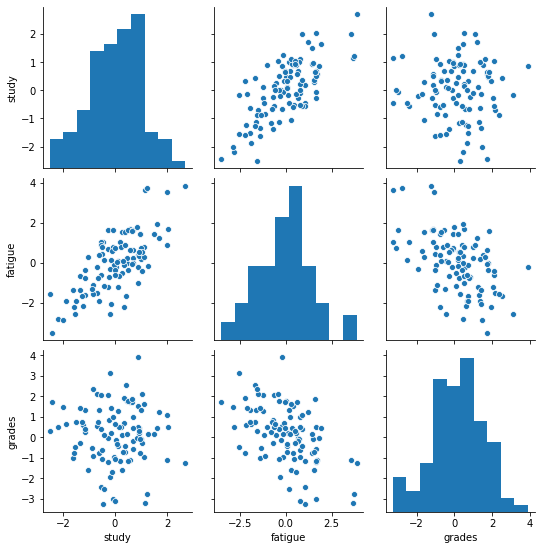

In [3]:
sns.pairplot(data=df)

In [4]:
df.corr()

,study,fatigue,grades
study,1.000000,0.722442,-0.030795
fatigue,0.722442,1.000000,-0.512935
grades,-0.030795,-0.512935,1.000000


### Regression  study -> grades

In [5]:
with pm.Model() as mk_model:
    a = pm.Normal('a', 0, 0.2)
    bS = pm.Normal('bS', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
 
    mu = pm.Deterministic('mu', a + bS*df['study'])
    grades = pm.Normal('grades', mu=mu, sigma=sigma, observed=df['grades'])
    
    sg_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bS, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:01<00:00, 6516.68draws/s]


In [6]:
varnames = ['~mu']
az.summary(sg_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.10,0.12,-0.13,0.31
bS,-0.04,0.14,-0.27,0.22
sigma,1.41,0.10,1.22,1.61


### Regression  tired -> grades

In [7]:
with pm.Model() as nk_model:
    a = pm.Normal('a', 0, 0.2)
    bF = pm.Normal('bF', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
 
    mu = pm.Deterministic('mu', a + bF*df['fatigue'])
    grades = pm.Normal('grades', mu=mu, sigma=sigma, observed=df['grades'])
    
    fg_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:01<00:00, 5897.33draws/s]


In [8]:
varnames = ['~mu']
az.summary(fg_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.11,0.10,-0.08,0.30
bF,-0.48,0.08,-0.63,-0.31
sigma,1.21,0.09,1.05,1.39


### Plots

In [9]:
sg_mu_pred = sg_trace['mu']
sg_mu_mean = sg_mu_pred.mean(0)

In [10]:
fg_mu_pred = fg_trace['mu']
fg_mu_mean = fg_mu_pred.mean(0)

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0, 0.5, 'grades')

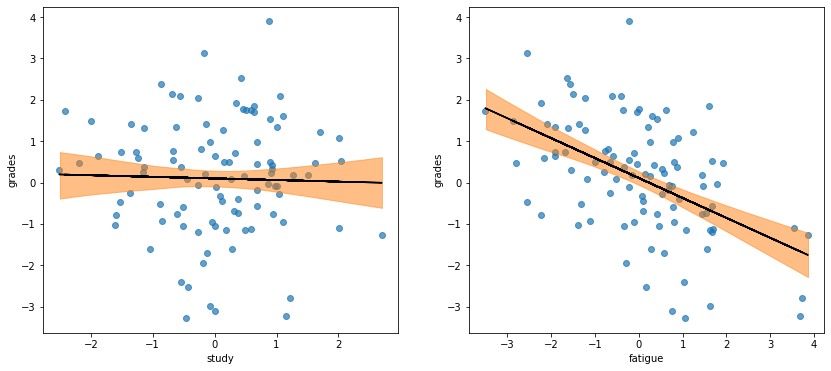

In [11]:
_, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(df.study, df.grades, alpha=0.7)
ax[0].plot(df.study, sg_mu_mean, color='black')
az.plot_hdi(df.study, sg_mu_pred, ax=ax[0], hdi_prob=0.89)
ax[0].set_xlabel('study')
ax[0].set_ylabel('grades')

ax[1].scatter(df.fatigue, df.grades, alpha=0.7)
ax[1].plot(df.fatigue, fg_mu_mean, color='black')
az.plot_hdi(df.fatigue, fg_mu_pred, ax=ax[1], hdi_prob=0.89)
ax[1].set_xlabel('fatigue')
ax[1].set_ylabel('grades')


As we can notice by summaries and the plots above **fatigue** has a correlation coeficient of **-0.48** with **grades**. However, **study** shows a small coeficient with a wide standard deviation around **0** to the outcome **grades**.

### Multivariate regression:   study -> grades <- tired

In [12]:
with pm.Model() as multi_model:
    a = pm.Normal('a', 0, 0.2)
    bS = pm.Normal('bS', 0, 0.5)
    bF = pm.Normal('bF', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
 
    mu = pm.Deterministic('mu', a + bF*df.fatigue + bS*df.study)
    grades = pm.Normal('grades', mu=mu, sigma=sigma, observed=df['grades'])
    
    sfg_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, bS, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:02<00:00, 4630.82draws/s]


In [13]:
varnames = ['~mu']
az.summary(sfg_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.10,0.09,-0.06,0.27
bS,0.87,0.14,0.60,1.11
bF,-0.92,0.10,-1.10,-0.74
sigma,1.01,0.07,0.88,1.16


Notice that in the multivariate regression how the coeficients **bS** and **bF** dramatically increased.
<br>
<br>
The value of **a** is quite close to **0** mainly because the data is standardised (mean=0, std=1), the more samples we draw the closer more it becomes zero-centered.
<br>
<br>
The two variables **study** and **fagigue** are correlated with **grades** but while **study** is positively correlated, **fatigue** is negatively correlated.  
<br>
<br>
On the forest plot bellow we can clearly notice the difference on both coeficients from the single variate models to the multivariate one.

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

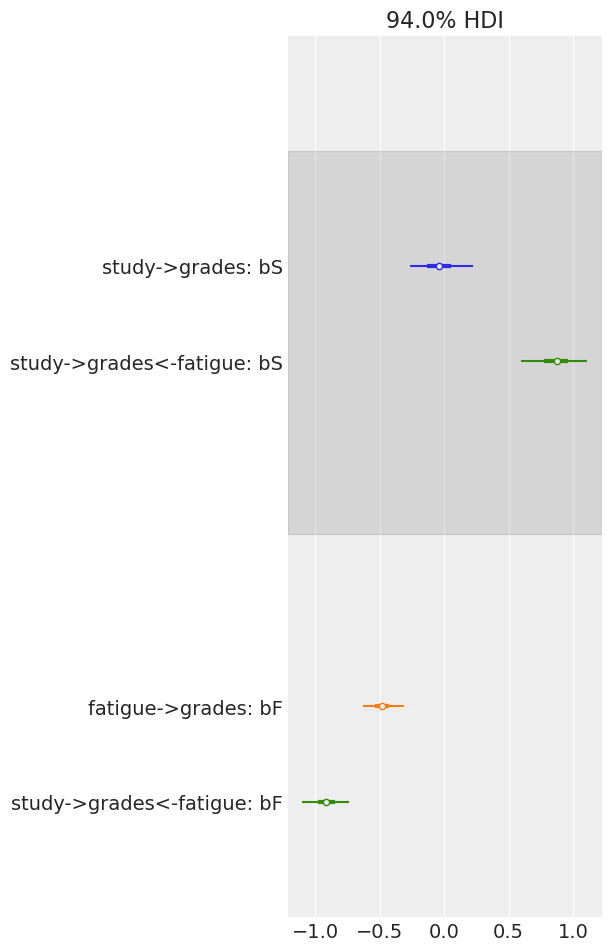

In [14]:
az.style.use("arviz-darkgrid")
az.plot_forest([sg_trace, fg_trace, sfg_trace], 
              model_names=["study->grades", "fatigue->grades", "study->grades<-fatigue"],
              var_names=["bS", "bF"],
              combined=True)

The multiple regression model in this case showed a masking correlation of 2 variables with the outcome. In this context one was positively correlated and the other one negatively correlated.
At the same time both predictors are correlated.

### DAG representation

We can represent the causal relationship with the following DAG(Directed Acyclic Graph):

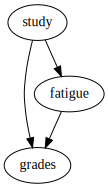

In [15]:
assoc = CausalGraphicalModel(
    nodes=["study", "fatigue", "grades"], edges=[("study", "grades"), ("fatigue", "grades"), ("study", "fatigue")]
)

assoc.draw()

In [16]:
%load_ext watermark
%watermark -iv -v -nuw

numpy   1.19.1
pandas  1.1.1
seaborn 0.10.1
pymc3   3.8
arviz   0.10.0
last updated: Mon Nov 02 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
